# Introduction to Coalescent Theory

This theory studies the **genealogical** relationships between individuals in a population. It provides a framework for understanding how genetic variation arises and is maintained over time. We start from a population of individuals and trace their lineages back in time to find their common ancestors. Some questions arises, for example:
- How long does it take for two individuals to share a common ancestor?
- What is the distribution of the number of ancestors at a given time in the past?
- How does the shape of the genealogical tree change over time?  

Differents models exist (Kingman coalescent, Lambda-coalescent, Wright-Fisher model, Moran model, etc.) to answer these questions and each of them assume different parameters and conditions like population size, mutation rate, coalescence rate, selection pressure (?), etc $\dots$

# Exercise 3 (Kingman coalescent)

We start with a simple model, Kingman coalescent, from our supervised learning class : `pdf/td4_simu_mapi3_corrige.pdf` (exercise 3)

Si 2 lignées quelconques peuvent coalescer à taux constant $c$, alors pour $n$ lignées, le taux de coalescence total est donné par les paires possibles de lignées ($\binom{n}{2}$) et par le lemme des réveils 
$$
T_{n-1} = \min_{i,j \leq n} T_{i,j} \sim \text{Exp}\left(c \binom{n}{2}\right)
$$

Soit $(E_{i,j})_{i<j}$ des v.a. i.i.d. $Exp(c)$, indépendantes de $F_{T_{k+1}}$ (évènements passé avant $T_{k+1}$).
Alors $$T_k - T_{k+1} = \min_{i<j} E_{i,j} \sim Exp(c \binom{k+1}{2})$$

Soit $(E_i)$ v.a. i.i.d. tq $E_1 \sim \text{Exp}(1)$, on rappel que $\frac{E_i}{c} \sim \text{Exp}(c)$. Donc, puisque $T_n=0$, donc par sommation telescopique,
$$T_k = \sum_{i=k}^{n-1} (T_k - T_{k+1}) + T_n \sim \sum_{i=k}^{n-1} \frac{E_i}{c \binom{k+1}{2}} $$

On note $T_{MRCA} = T_1$ le temps jusqu'au MRCA (Most Recent Common Ancestor) de $n$ lignées. Donc,
$$T_{MRCA} \sim \sum_{i=1}^{n-1} \frac{E_i}{c \binom{i+1}{2}} $$

$$\mathbb E(T_{MRCA}) = \sum_{i=1}^{n-1} \mathbb E\left(\frac{E_i}{c \binom{i+1}{2}}\right) = \sum_{i=1}^{n-1} \frac{1}{c \binom{i+1}{2}} = \frac{2}{c} \sum_{i=1}^{n-1} \frac{1}{i(i+1)} = \frac{2}{c} \left(1 - \frac{1}{n}\right)$$

# 

# TP — Simulation du coalescent de Kingman (Q5)


Nous répondons ici aux questions 5(a)–(c) :


- (a) Tracer le nombre de lignées au cours du temps pour n = 10000.
- (b) Estimer numériquement E(T_{MRCA}) et comparer à la valeur théorique.
- (c) Tracer la distribution empirique de T_{MRCA} pour différents n et commenter.

In [15]:
# Setup: imports, RNG, and default parameters


import numpy as np


import matplotlib.pyplot as plt


from math import comb




# Use a dedicated RNG for reproducibility (change the seed if desired)

rng = np.random.default_rng(42)



# Coalescence rate per pair (Kingman): c > 0

c = 1.0  # you can modify this if needed

In [16]:
# Functions: simulate full path and sample T_MRCA fast

from typing import Optional



def simulate_kingman_full_path(n: int, c: float = 1.0, rng: Optional[np.random.Generator] = None):

    """

    Simulate the Kingman coalescent backward in time from n lineages until MRCA.



    Returns:

      times: 1D numpy array of event times (starting at 0, ending at T_MRCA)

      k_values: 1D numpy array of number of lineages just AFTER each event (starts at n, ends at 1)

    """

    if n < 2:

        raise ValueError("n must be >= 2")

    if rng is None:

        rng = np.random.default_rng()



    times = [0.0]

    k_values = [n]

    t = 0.0

    k = n

    while k > 1:

        rate = c * (k * (k - 1) / 2.0)  # c * C(k,2)

        wait = rng.exponential(1.0 / rate)

        t += wait

        times.append(t)

        k -= 1

        k_values.append(k)



    return np.array(times), np.array(k_values)





def sample_TMRCA(n: int, R: int = 1000, c: float = 1.0, rng: Optional[np.random.Generator] = None, batch_size: Optional[int] = None):

    """

    Draw R i.i.d. samples of T_MRCA for Kingman coalescent with n lineages.

    Vectorized (and optionally batched) using the representation

      T_MRCA = sum_{k=2}^n Exp(c * C(k,2)).



    Returns:

      1D numpy array of length R.

    """

    if n < 2:

        raise ValueError("n must be >= 2")

    if rng is None:

        rng = np.random.default_rng()



    ks = np.arange(2, n + 1, dtype=float)

    rates = c * (ks * (ks - 1.0) / 2.0)  # c * C(k,2)

    scales = 1.0 / rates



    if batch_size is None:

        # Full vectorization (watch memory for large n*R)

        X = rng.exponential(scale=scales[:, None], size=(n - 1, R))

        return X.sum(axis=0)

    else:

        out = np.empty(R, dtype=float)

        start = 0

        while start < R:

            end = min(start + batch_size, R)

            m = end - start

            X = rng.exponential(scale=scales[:, None], size=(n - 1, m))

            out[start:end] = X.sum(axis=0)

            start = end

        return out





def theoretical_E_TMRCA(n: int, c: float = 1.0) -> float:

    """E[T_MRCA] = 2/c * (1 - 1/n)."""

    return (2.0 / c) * (1.0 - 1.0 / n)

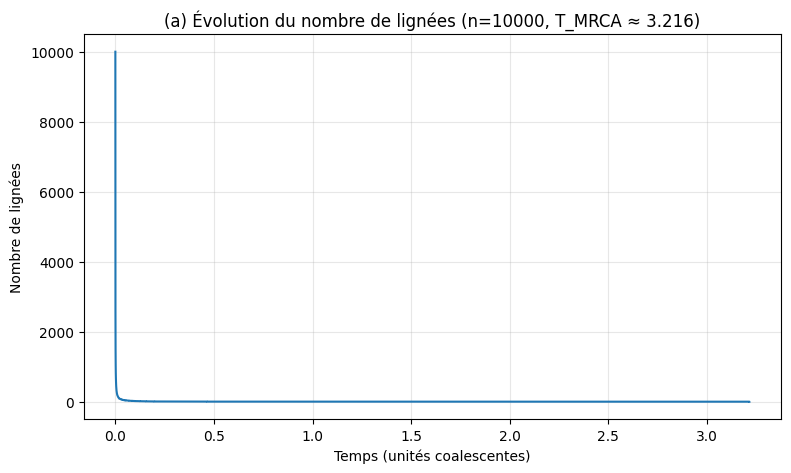

T_MRCA simulé (n=10000): 3.216288
E[T_MRCA] théorique: 1.999800


In [17]:
# (a) Tracer le nombre de lignées au cours du temps pour n = 10000



n_a = 10_000

times, k_values = simulate_kingman_full_path(n_a, c=c, rng=rng)

T_mrca_a = times[-1]



plt.figure(figsize=(9, 5))

plt.step(times, k_values, where='post')

plt.xlabel('Temps (unités coalescentes)')

plt.ylabel('Nombre de lignées')

plt.title(f"(a) Évolution du nombre de lignées (n={n_a}, T_MRCA ≈ {T_mrca_a:.3f})")

plt.grid(True, alpha=0.3)

plt.show()



print(f"T_MRCA simulé (n={n_a}): {T_mrca_a:.6f}")

print(f"E[T_MRCA] théorique: {theoretical_E_TMRCA(n_a, c=c):.6f}")

### Observations pour (a)


- Les premières coalescences sont très rapides car le taux total est \(c\,\binom{k}{2}\), énorme quand \(k\) est grand.
- La courbe décroît donc très vite au début, puis de plus en plus lentement lorsque \(k\) devient petit.
- La majeure partie du temps jusqu'au MRCA est passée avec un nombre de lignées faible (effet « goulot d'étranglement » temporel).

In [18]:
# (b) Estimation numérique de E[T_MRCA] et comparaison à la valeur théorique



n_b = 10_000

R_b = 300  # nombre de répétitions Monte Carlo (augmenter si besoin)



t_samples_b = sample_TMRCA(n_b, R=R_b, c=c, rng=rng, batch_size=100)



emp_mean = float(np.mean(t_samples_b))

emp_std = float(np.std(t_samples_b, ddof=1))

theo_mean = theoretical_E_TMRCA(n_b, c=c)



# Intervalle de confiance 95% (approx. normal) pour la moyenne

half_ci = 1.96 * emp_std / np.sqrt(R_b)



print(f"(b) E[T_MRCA] empirique (n={n_b}, R={R_b}): {emp_mean:.6f} ± {half_ci:.6f} (95% CI)")

print(f"    E[T_MRCA] théorique: {theo_mean:.6f}")

(b) E[T_MRCA] empirique (n=10000, R=300): 2.004024 ± 0.112159 (95% CI)
    E[T_MRCA] théorique: 1.999800


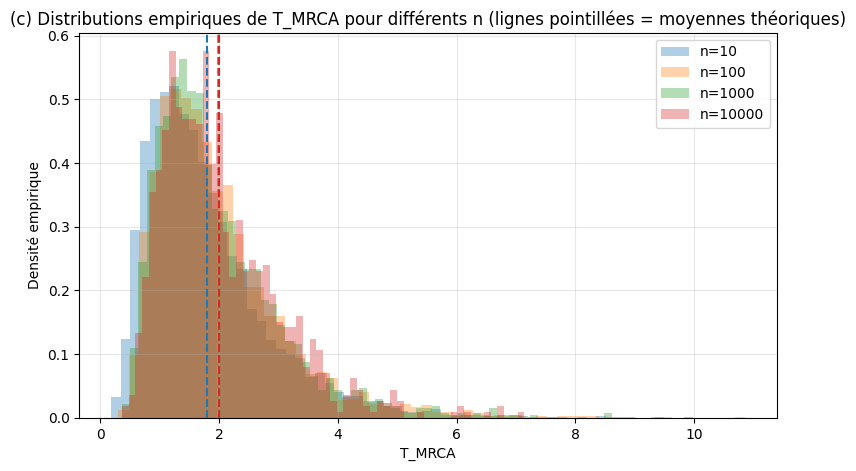

In [19]:
# (c) Distribution empirique de T_MRCA pour différents n



ns = [10, 100, 1000, 10_000]

R_map = {10: 10_000, 100: 5_000, 1000: 2_000, 10_000: 1_000}

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']



plt.figure(figsize=(9, 5))

for n, color in zip(ns, colors):

    R = R_map[n]

    t_samples = sample_TMRCA(n, R=R, c=c, rng=rng, batch_size=250)

    plt.hist(t_samples, bins=60, density=True, alpha=0.35, color=color, label=f"n={n}")

    plt.axvline(theoretical_E_TMRCA(n, c=c), color=color, linestyle='--', linewidth=1.5)



plt.xlabel('T_MRCA')

plt.ylabel('Densité empirique')

plt.title("(c) Distributions empiriques de T_MRCA pour différents n (lignes pointillées = moyennes théoriques)")

plt.grid(True, alpha=0.3)

plt.legend()

plt.show()

### Commentaires pour (c)


- Quand \(n\) augmente, la moyenne théorique \(\mathbb E[T_{MRCA}] = 2/c\,(1-1/n)\) se rapproche de \(2/c\).


- La variabilité de \(T_{MRCA}\) diminue avec \(n\) : la distribution se concentre près de sa moyenne.
- La loi n'est pas exponentielle : \(T_{MRCA}\) est une somme d'exponentielles indépendantes de taux \(c\,\binom{k}{2}\) (distribution hypoexponentielle).

## Justification rigoureuse de la loi de T_k - T_{k+1}


Notons $(\mathcal F_t)$ la filtration naturelle et $T_k$ le temps auquel il reste $k$ lignées (ce sont des temps d'arrêt). Au temps $T_{k+1}$, il reste $m=k+1$ lignées. Dans le coalescent de Kingman :



- chaque paire non ordonnée $\{i,j\}$ parmi les $\binom{m}{2}$ paires coalesce à taux $c$ ;

- les horloges associées aux paires sont indépendantes entre elles et indépendantes du passé $\mathcal F_{T_{k+1}}$ (Markov forte + absence de mémoire des exponentielles).



Soit $(E_{i,j})_{i<j}$ des v.a. i.i.d. $\mathrm{Exp}(c)$, indépendantes de $\mathcal F_{T_{k+1}}$. Le prochain temps de coalescence après $T_{k+1}$ est

$$T_k - T_{k+1} = \min_{i<j} E_{i,j}.$$



Conditionnellement à $\mathcal F_{T_{k+1}}$, pour $t\ge 0$ :

\[\begin{aligned}

\mathbb P\big(T_k - T_{k+1} > t \mid \mathcal F_{T_{k+1}}\big)

&= \mathbb P\Big(\forall i<j,\ E_{i,j}>t\ \Big|\ \mathcal F_{T_{k+1}}\Big)\\

&= \prod_{i<j} \mathbb P(E_{i,j}>t)\\

&= (e^{-ct})^{\binom{m}{2}} = e^{-c\binom{k+1}{2} t}.

\end{aligned}\]



Ainsi, $T_k - T_{k+1}\,|\,\mathcal F_{T_{k+1}} \sim \mathrm{Exp}\big(c\,\binom{k+1}{2}\big)$ et cette loi ne dépend pas du passé. En particulier, inconditionnellement :

$$T_k - T_{k+1} \sim \mathrm{Exp}\big(c\,\binom{k+1}{2}\big).$$



Rappel utile : le minimum de $N$ exponentielles i.i.d. de paramètre $c$ est exponentielle de paramètre $Nc$.

In [20]:
# Utils: simulate a Kingman coalescent tree (topology + branch lengths) and plot it simply

from typing import Dict, Any, Tuple



def simulate_kingman_tree(n: int, c: float = 1.0, rng: Optional[np.random.Generator] = None) -> Tuple[Dict[int, Dict[str, Any]], int]:

    """

    Returns (nodes, root_id) where nodes[id] = { 'left': int|None, 'right': int|None, 'time': float }.

    Leaves have ids 0..n-1 at time 0. Internal nodes have ids n..(2n-2).

    """

    if n < 2:

        raise ValueError("n must be >= 2")

    if rng is None:

        rng = np.random.default_rng()



    nodes: Dict[int, Dict[str, Any]] = {i: {'left': None, 'right': None, 'time': 0.0} for i in range(n)}

    active = list(range(n))

    next_id = n

    t = 0.0

    while len(active) > 1:

        k = len(active)

        rate = c * (k * (k - 1) / 2.0)

        t += rng.exponential(1.0 / rate)

        # pick two distinct indices in active

        i, j = rng.choice(k, size=2, replace=False)

        a, b = active[i], active[j]

        # create parent

        nodes[next_id] = {'left': a, 'right': b, 'time': t}

        # update active list (remove by index descending to avoid reindexing issues)

        for idx in sorted([i, j], reverse=True):

            active.pop(idx)

        active.append(next_id)

        next_id += 1



    root = active[0]

    return nodes, root





def plot_coalescent_tree(nodes: Dict[int, Dict[str, Any]], root: int, ax=None, linecolor='tab:gray', lw=1.2, annotate_leaves=False):

    """

    Simple horizontal-time tree plot. Leaves at time 0; internal nodes to the right.

    """

    if ax is None:

        ax = plt.gca()



    y_pos: Dict[int, float] = {}

    y_cursor = [0.0]



    def draw(node: int) -> float:

        info = nodes[node]

        left, right, time = info['left'], info['right'], info['time']

        if left is None and right is None:

            y = y_cursor[0]

            y_cursor[0] += 1.0

            y_pos[node] = y

            if annotate_leaves:

                ax.text(0.0, y, str(node), va='center', ha='right', fontsize=7)

            return y

        yl = draw(left)

        yr = draw(right)

        # horizontal branches from child times to parent time

        ax.plot([nodes[left]['time'], time], [yl, yl], color=linecolor, lw=lw)

        ax.plot([nodes[right]['time'], time], [yr, yr], color=linecolor, lw=lw)

        # vertical connector at parent time

        ax.plot([time, time], [yl, yr], color=linecolor, lw=lw)

        y = 0.5 * (yl + yr)

        y_pos[node] = y

        return y



    draw(root)

    ax.set_xlabel('Temps (unités coalescentes)')

    ax.set_ylabel('Lignées')

    ax.grid(True, axis='x', alpha=0.2)

    # T_MRCA is time at root

    ax.set_title(f"Arbre coalescent (T_MRCA ≈ {nodes[root]['time']:.3f})")

    # Tight y-limits

    ax.set_ylim(-0.5, max(y_pos.values()) + 0.5)

    return ax

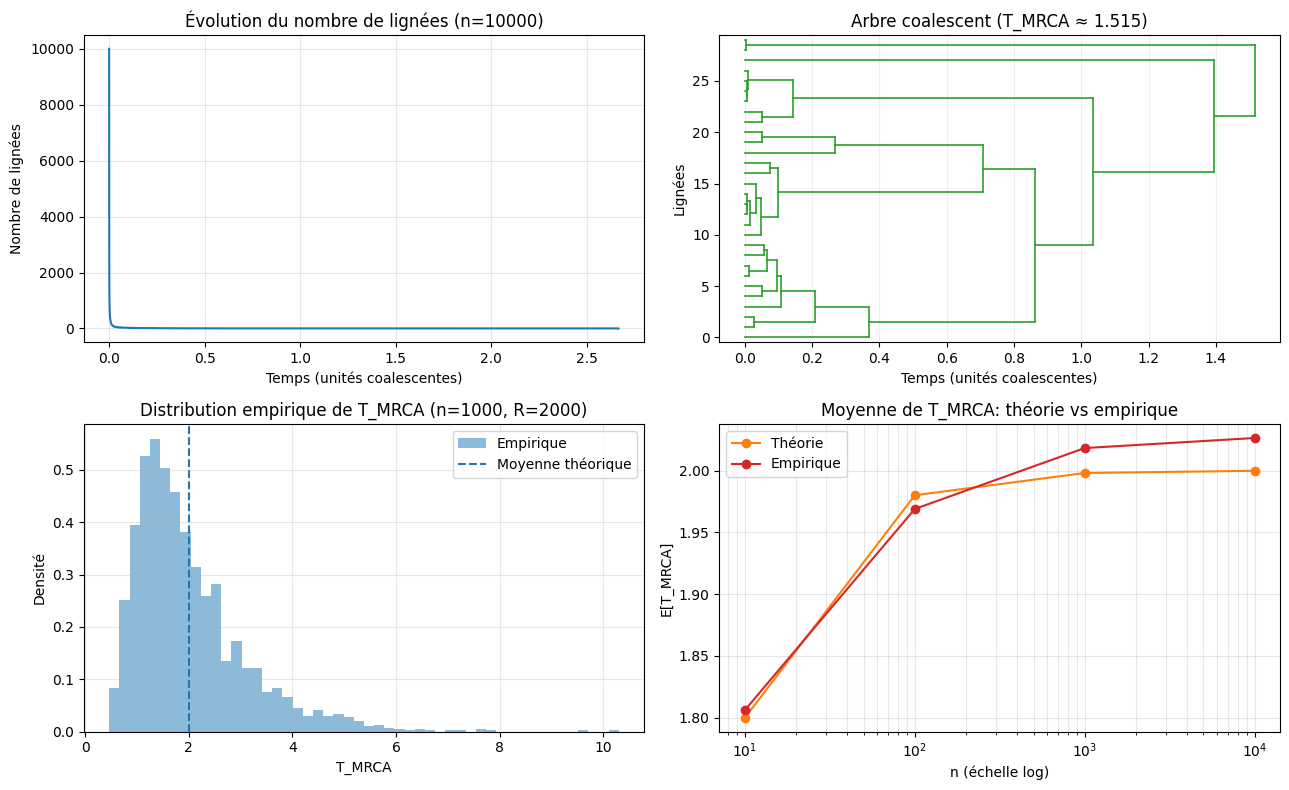

In [23]:
# Subplots: vue d'ensemble simple et parlante



# Params you can tweak

n_large = 10_000       # for k(t)

n_tree  = 30           # for tree plot (keep small for readability)

n_hist  = 1_000        # for histogram

R_hist  = 2_000        # repetitions for histogram

ns_mean = [10, 100, 1000, 10_000]  # for mean comparison



# 1) Large-n path for k(t)

times_large, k_values_large = simulate_kingman_full_path(n_large, c=c, rng=rng)



# 2) Small-n tree

nodes, root = simulate_kingman_tree(n_tree, c=c, rng=rng)



# 3) Histogram for one n

t_hist = sample_TMRCA(n_hist, R=R_hist, c=c, rng=rng, batch_size=250)



# 4) Empirical vs theoretical means across ns

emp_means = []

theo_means = []

for n in ns_mean:

    Rn = min(5000, max(1000, 100000 // n))  # simple heuristic for speed/accuracy

    t_samp = sample_TMRCA(n, R=Rn, c=c, rng=rng, batch_size=250)

    emp_means.append(float(np.mean(t_samp)))

    theo_means.append(theoretical_E_TMRCA(n, c=c))



fig, axs = plt.subplots(2, 2, figsize=(13, 8))



# Top-left: k(t)

ax = axs[0, 0]

ax.step(times_large, k_values_large, where='post')

ax.set_title(f"Évolution du nombre de lignées (n={n_large})")

ax.set_xlabel('Temps (unités coalescentes)')

ax.set_ylabel('Nombre de lignées')

ax.grid(True, alpha=0.3)



# Top-right: Tree

ax = axs[0, 1]

plot_coalescent_tree(nodes, root, ax=ax, linecolor='tab:green', lw=1.2, annotate_leaves=False)



# Bottom-left: Histogram for n_hist

ax = axs[1, 0]

ax.hist(t_hist, bins=50, density=True, color='tab:blue', alpha=0.5, label='Empirique')

ax.axvline(theoretical_E_TMRCA(n_hist, c=c), color='tab:blue', linestyle='--', label='Moyenne théorique')

ax.set_title(f"Distribution empirique de T_MRCA (n={n_hist}, R={R_hist})")

ax.set_xlabel('T_MRCA')

ax.set_ylabel('Densité')

ax.grid(True, alpha=0.3)

ax.legend()



# Bottom-right: Means across n

ax = axs[1, 1]

ax.plot(ns_mean, theo_means, '-o', label='Théorie', color='tab:orange')

ax.plot(ns_mean, emp_means, '-o', label='Empirique', color='tab:red')

ax.set_xscale('log')

ax.set_xlabel('n (échelle log)')

ax.set_ylabel('E[T_MRCA]')

ax.set_title('Moyenne de T_MRCA: théorie vs empirique')

ax.grid(True, which='both', alpha=0.3)

ax.legend()



plt.tight_layout()

plt.show()

### À quoi regarder sur ces subplots ?


- En haut à gauche, la décroissance ultra-rapide du nombre de lignées quand \(k\) est grand, suivie d’un long « plateau » à petit \(k\).


- En haut à droite, l’arbre coalescent pour un \(n\) modéré : les branches proches des feuilles sont courtes et nombreuses, puis les dernières coalescences concentrent la majorité du temps.
- En bas à gauche, la loi empirique de \(T_{MRCA}\) pour un \(n\) fixe, avec la moyenne théorique en pointillé.
- En bas à droite, la moyenne empirique vs théorique selon \(n\) : on voit la convergence vers \(2/c\) quand \(n\to\infty\).


Paramètres modifiables en haut de la cellule de subplots (n_tree, n_hist, R_hist, etc.).

In [22]:
# Quick stats: T_MRCA empirical summaries across n

ns_stats = [10, 30, 100, 300, 1000, 10_000]



def summarize_TMRCA(n, c=1.0, R=None):

    # Simple heuristic for repetitions

    if R is None:

        R = min(10_000, max(1_000, 60_000 // n))

    samples = sample_TMRCA(n, R=R, c=c, rng=rng, batch_size=250)

    mean = float(np.mean(samples))

    sd   = float(np.std(samples, ddof=1))

    q05, q50, q95 = [float(np.quantile(samples, q)) for q in (0.05, 0.50, 0.95)]

    return {

        'n': n,

        'R': R,

        'mean_emp': mean,

        'sd_emp': sd,

        'cv_emp': sd / mean,

        'q05': q05,

        'q50': q50,

        'q95': q95,

        'mean_theo': theoretical_E_TMRCA(n, c=c)

    }



rows = [summarize_TMRCA(n, c=c) for n in ns_stats]

print("n    R     mean_emp   mean_theo   sd_emp   CV     q05    q50    q95")

for r in rows:

    print(f"{r['n']:>5} {r['R']:>6}  {r['mean_emp']:.4f}   {r['mean_theo']:.4f}   "

          f"{r['sd_emp']:.4f}  {r['cv_emp']:.3f}  {r['q05']:.3f}  {r['q50']:.3f}  {r['q95']:.3f}")

n    R     mean_emp   mean_theo   sd_emp   CV     q05    q50    q95
   10   6000  1.7841   1.8000   1.0687  0.599  0.598  1.539  3.854
   30   2000  1.9564   1.9333   1.1414  0.583  0.705  1.691  4.143
  100   1000  1.9598   1.9800   1.0880  0.555  0.784  1.705  4.199
  300   1000  2.0362   1.9933   1.1188  0.549  0.813  1.785  3.992
 1000   1000  1.9733   1.9980   1.0614  0.538  0.814  1.703  3.952
10000   1000  2.0485   1.9998   1.1258  0.550  0.805  1.796  4.184
